In [2]:
from scipy import optimize
import scipy.stats as st
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt
import scipy.io
from sklearn.linear_model import LinearRegression
import os.path
from os import path
import netCDF4
from statsmodels.tsa.stattools import acf
import netCDF4 as nc
import warnings
warnings.filterwarnings("ignore")


def piecewise_linear(x, x0, y0, k1, k2):
#   Compute optimization of fitting two connected linregs to data.
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def df_autocorr(df, lag=1, axis=0):
#   Compute full-sample column-wise autocorrelation for a DataFrame.
    return df.apply(lambda col: col.autocorr(lag), axis=axis)
"""
        optimize.curve_fit does the heavy lifting. p & e are 4-element series of results and error/uncertainties for:
        [0] : X or soil moisture value for breakpoint
        [1] : Y (T, flux, etc.) value for breakpoint
        [2] : Slope on left side of breakpoint
        [3] : slope on right side of breakpoint
        piecewise_linear is defined above - the function to optimize over
        Next 2 arguments are X and Y series (sorted on X) of daily data
        p0 is an optional first guess for each of the 4 predicted parameters
        bounds sets limits
"""        
pair_list=np.load('/homes/hhsu/02.InfoTheo/FluxNet/pair_list.npy')
pair_list

txtfile = '/homes/hhsu/02.InfoTheo/FluxNet/FluxNet_site_info.txt'
id = []     # The number of the site
name = []   # The name of the site
lat = []    # latitude of the site
lon = []    # lontitude of the site
lct = []    # IGBP classification of the site
gns = []    # Vegetation cover level of the site
pool = []   # to mark if the site is taken by a previous detected pair: >0: available   /   0: already taken
elv = []    # elevation of the site
exis = []   # to mark if the site is included in FLUXNET2015 with CC by 4.9
smdata=[]




pair_list=np.array([np.full((150,2),-999)]) # recording the pair by id
diag_distance=np.array([np.full((150,2),-999)]) # Calculating the distance between all site and a given site (as the reference) for making further site spatial visualization 
newid=np.array([np.full((150,2),-999)])   # Give the pair_list a id to make further site spatial visualization 
lonnew=np.array([np.full((150,2),-999)])  # latitude of the site of sites in pair_list
latnew=np.array([np.full((150,2),-999)])  # latitude of the site of sites in pair_list
with open(txtfile) as f:
    for line in f.readlines():
        s = line.split('\t')
        id.append((s[0]))
        name.append((s[1]))
        lat.append(float(s[2])+90)
        lon.append(float(s[3])+180)
        lct.append((s[4]))
        gns.append(int(s[5]))
        pool.append(int(s[0]))
        elv.append(float(s[6]))
        exis.append(int(s[7]))

        

FLX_CN-Qia_FLUXNET2015_FULLSET_HH_2003-2005_1-4.csv


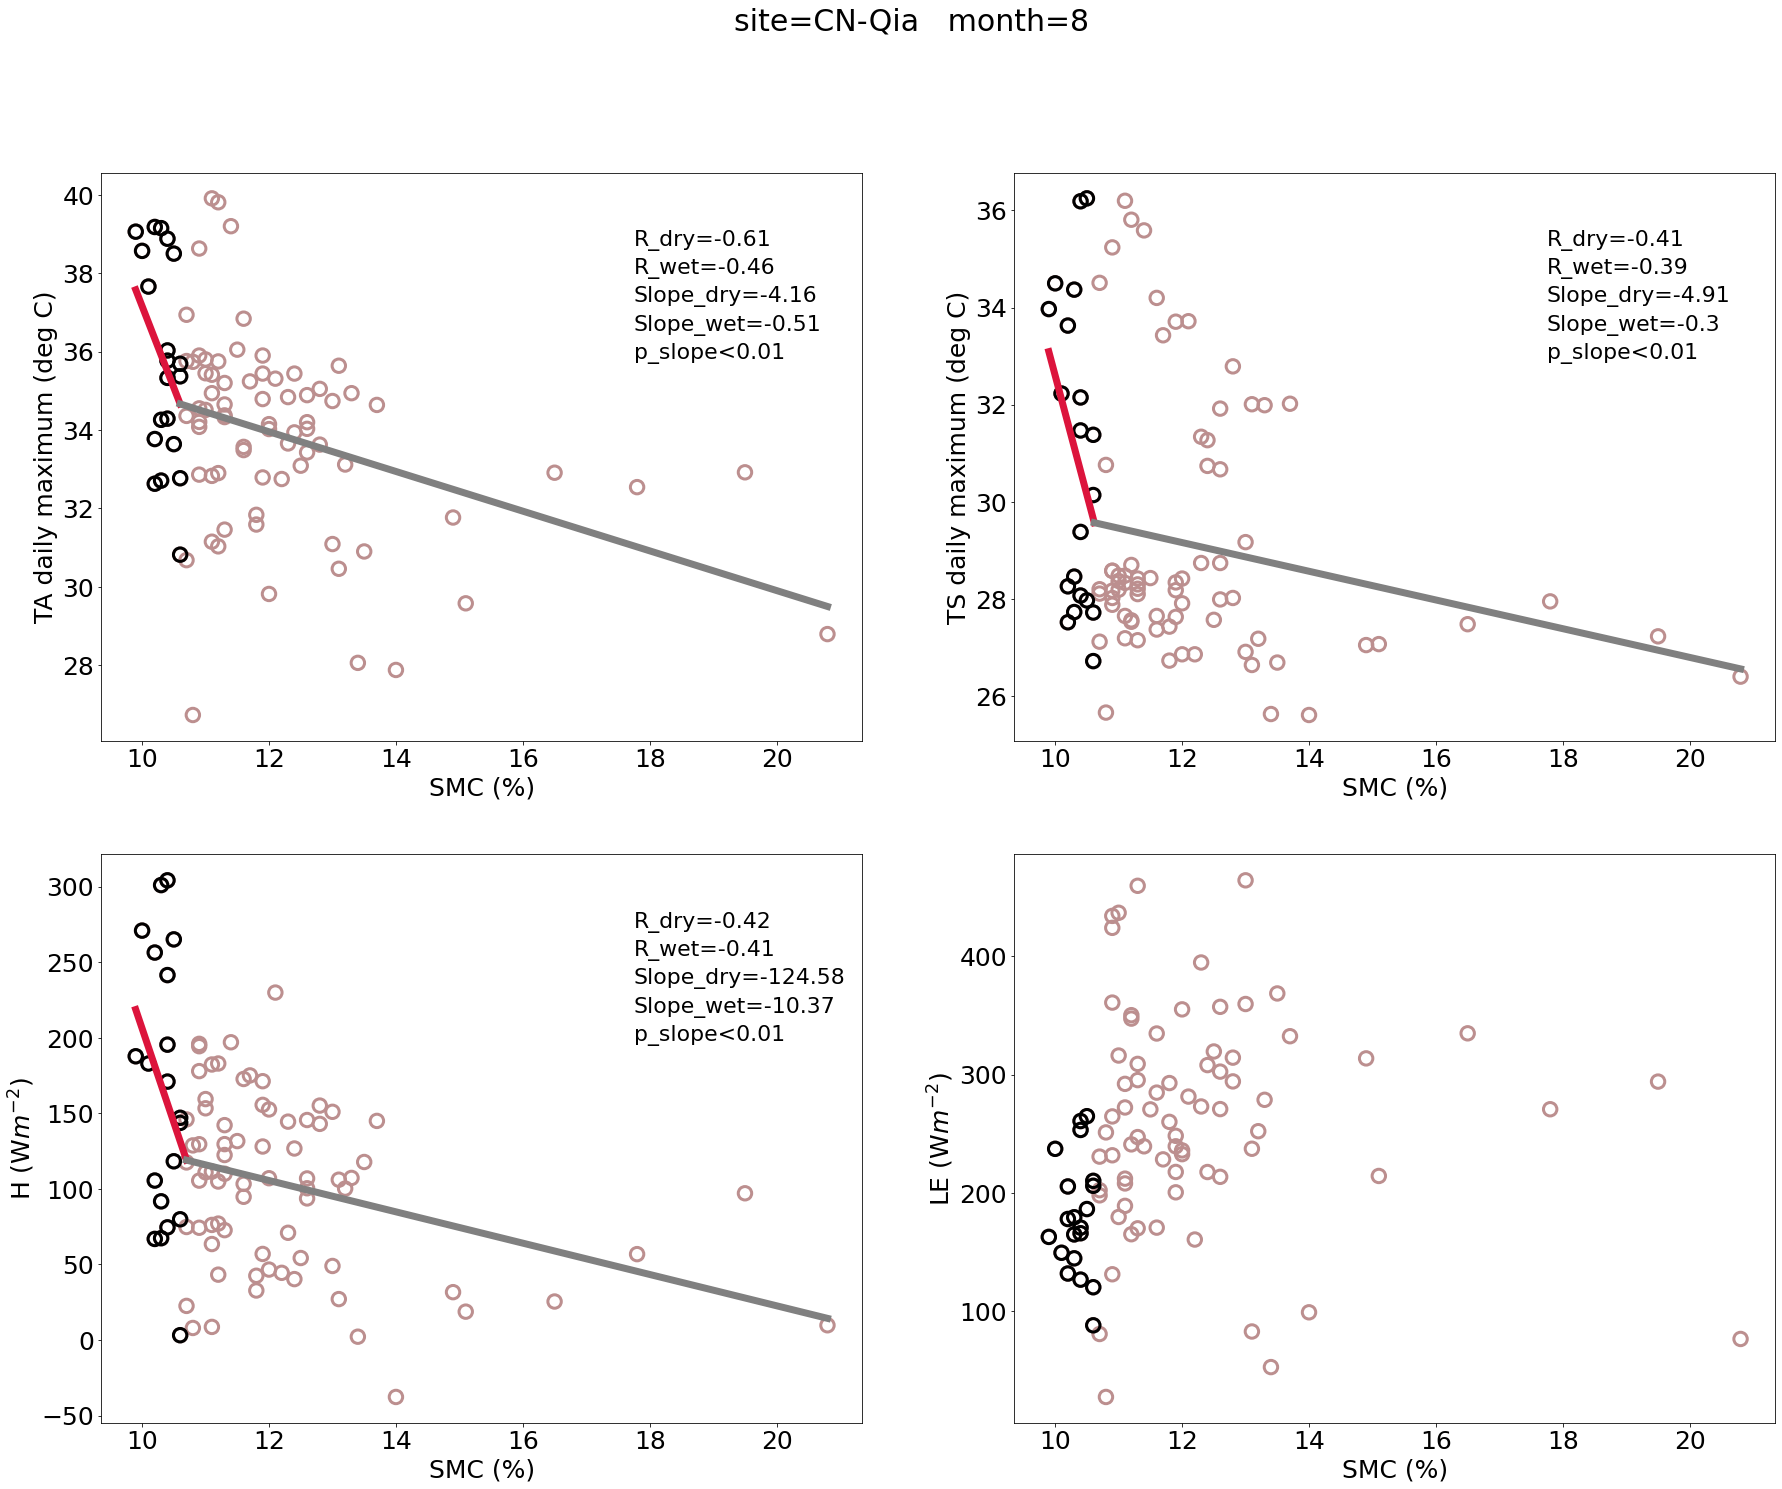

In [8]:
#Read file by globally seaching the file name with corresponding site name

import glob
import os
os.chdir('/shared/land/FluxTowers/FLUXNET2015/CC-BY-4.0_202002/FULLSET/HX')
"""
H_F_MDS
LE_F_MDS
LW_OUT

#list of data:
# 0: pair number
# 1: site A's name
# 2: site A's veg level
# 3: site B's name
# 4: site B's veg level
# 5: spearmanr of SM
# 6: spearmanr of Tmax
# 7: Analyzed month: selected by max of monthly Tmax

# 11: site A's bk analysis: simple regression interception
# 12: site A's bk analysis: simple regression slope
# 13: site A's bk analysis: simple regression dof
# 15: site A's bk analysis: simple regression RRS
# 16: site A's bk analysis: simple regression BIC

# 21: site A's bk analysis: piecewise regression SM breakpoint
# 22: site A's bk analysis: piecewise regression Tmax breakpoint
# 23: site A's bk analysis: piecewise regression LHS slope
# 24: site A's bk analysis: piecewise regression RHS slope
# 25: site A's bk analysis: piecewise regression RRS
# 26: site A's bk analysis: piecewise regression BIC

# 31: site B's bk analysis: simple regression interception
# 32: site B's bk analysis: simple regression slope
# 33: site B's bk analysis: simple regression dof
# 35: site B's bk analysis: simple regression RRS
# 36: site B's bk analysis: simple regression BIC

# 41: site B's bk analysis: piecewise regression SM breakpoint
# 42: site B's bk analysis: piecewise regression Tmax breakpoint
# 43: site B's bk analysis: piecewise regression LHS slope
# 44: site B's bk analysis: piecewise regression RHS slope
# 45: site B's bk analysis: piecewise regression RRS
# 46: site B's bk analysis: piecewise regression BIC
"""

guess_dry_slope, guess_wet_slope = -50.0, -25.0
#np.size(name)
for listn in range(0 ,1):
    
    SM_siteA=[]
    H_siteA=[]
    LE_siteA=[]
    G_siteA=[]
    dTS_siteA=[]
    if (listn>-1) :
        pass
        common_index=0
        siteA='CN-Qia'
        for file in glob.glob("FLX_" + siteA + "*"):
            print(file)
        csvfileA="/shared/land/FluxTowers/FLUXNET2015/CC-BY-4.0_202002/FULLSET/HX/" +file
      
        data_siteA = pd.read_csv(csvfileA) 
        #column_headers = list(data_siteB.columns.values)
        #print("The Column Header :", column_headers)

        #Tmax, ta_0700, ta_0900 

        if ('TA_F_MDS' in data_siteA.columns): 
            res = np.array(data_siteA['TIMESTAMP_START'].values.tolist())
            time=np.array(np.full((len(res)),"0000000000000000")) 

            for i in range(0 ,int(len(res))):
                a=str(res[i])
                time[i]= a[0:4] + "-" +  a[4:6] + "-" + a[6:8] 

            data_siteA['date'] = time
            data_siteA['date'] = pd.to_datetime(data_siteA['date'],  errors='coerce')           
            Tmin_max_siteA=data_siteA.groupby(pd.Grouper('date'))['TA_F_MDS'].agg(['max'])
            Tmin_max_siteA=Tmin_max_siteA['max'].replace(-9999.0, np.NaN)
            Tmin_max_siteA=Tmin_max_siteA.to_frame()
            
        if ('TS_F_MDS_1' in data_siteA.columns): 
            res = np.array(data_siteA['TIMESTAMP_START'].values.tolist())
            time=np.array(np.full((len(res)),"0000000000000000")) 

            for i in range(0 ,int(len(res))):
                a=str(res[i])
                time[i]= a[0:4] + "-" +  a[4:6] + "-" + a[6:8] 

            data_siteA['date'] = time
            data_siteA['date'] = pd.to_datetime(data_siteA['date'],  errors='coerce')           
            Ts_max_siteA=data_siteA.groupby(pd.Grouper('date'))['TS_F_MDS_1'].agg(['max'])
            Ts_max_siteA=Ts_max_siteA['max'].replace(-9999.0, np.NaN)
            Ts_max_siteA=Ts_max_siteA.to_frame()

        if ('H_F_MDS' in data_siteA.columns): 
    
            res = np.array(data_siteA['TIMESTAMP_START'].values.tolist())
            time=np.array(np.full((len(res)),"0000000000000000")) 

            for i in range(0 ,int(len(res))):
                a=str(res[i])
                time[i]= a[8:10] + "" +  a[10:12]

            data_siteA['hour'] = time
            a=data_siteA[data_siteA["hour"] == '0900']['H_F_MDS']
            b=data_siteA[data_siteA["hour"] == '1000']['H_F_MDS']
            c=data_siteA[data_siteA["hour"] == '1100']['H_F_MDS']
            d=data_siteA[data_siteA["hour"] == '1200']['H_F_MDS']

            a.index=Tmin_max_siteA.index
            b.index=Tmin_max_siteA.index
            c.index=Tmin_max_siteA.index
            d.index=Tmin_max_siteA.index
            
            SM_siteA=(a.to_frame()+b.to_frame()+c.to_frame()+d.to_frame())/4

            H_siteA=SM_siteA['H_F_MDS'].replace(-9999.0, np.NaN)
            H_siteA=H_siteA.to_frame()
            
        if ('LE_F_MDS' in data_siteA.columns): 
    
            res = np.array(data_siteA['TIMESTAMP_START'].values.tolist())
            time=np.array(np.full((len(res)),"0000000000000000")) 

            for i in range(0 ,int(len(res))):
                a=str(res[i])
                time[i]= a[8:10] + "" +  a[10:12]

            data_siteA['hour'] = time
            a=data_siteA[data_siteA["hour"] == '0900']['LE_F_MDS']
            b=data_siteA[data_siteA["hour"] == '1000']['LE_F_MDS']
            c=data_siteA[data_siteA["hour"] == '1100']['LE_F_MDS']
            d=data_siteA[data_siteA["hour"] == '1200']['LE_F_MDS']

            a.index=Tmin_max_siteA.index
            b.index=Tmin_max_siteA.index
            c.index=Tmin_max_siteA.index
            d.index=Tmin_max_siteA.index
            
            SM_siteA=(a.to_frame()+b.to_frame()+c.to_frame()+d.to_frame())/4

            LE_siteA=SM_siteA['LE_F_MDS'].replace(-9999.0, np.NaN)
            LE_siteA=LE_siteA.to_frame()           
            

            
            
        if ('SWC_F_MDS_1' in data_siteA.columns): 
    
            res = np.array(data_siteA['TIMESTAMP_START'].values.tolist())
            time=np.array(np.full((len(res)),"0000000000000000")) 

            for i in range(0 ,int(len(res))):
                a=str(res[i])
                time[i]= a[8:10] + "" +  a[10:12]

            data_siteA['hour'] = time
            a=data_siteA[data_siteA["hour"] == '0900']['SWC_F_MDS_1']
            a.index=Tmin_max_siteA.index
            SM_siteA=a.to_frame()

            SM_siteA=SM_siteA['SWC_F_MDS_1'].replace(-9999.0, np.NaN)
            SM_siteA=SM_siteA.to_frame()
            


         
            #Compare the available date and keep same date of data
 #   SW_IN_F_MDS_siteA=[]
 #   LW_IN_F_MDS_siteA=[]
 #   SW_OUT_siteA=[]
            common_index = set(Tmin_max_siteA.index).intersection(SM_siteA.index)
            if len(common_index) > 0:
                try:
                    Tmin_max_siteA = Tmin_max_siteA.loc[common_index].copy()
                    Tmin_max_siteA = Tmin_max_siteA.sort_values(by='date')
                except:
                    pass

                try:

                    SM_siteA = SM_siteA.loc[common_index].copy()
                    SM_siteA = SM_siteA.sort_values(by='date')
                except:
                    pass
                try:

                    H_siteA = H_siteA.loc[common_index].copy()
                    H_siteA = H_siteA.sort_values(by='date')
                except:
                    pass
                try:

                    LE_siteA = LE_siteA.loc[common_index].copy()
                    LE_siteA = LE_siteA.sort_values(by='date')
                except:
                    pass

                try:

                    Ts_max_siteA = Ts_max_siteA.loc[common_index].copy()
                    Ts_max_siteA = Ts_max_siteA.sort_values(by='date')
                except:
                    pass
     
                try:
                    Tmin_max_siteA_ano = Tmin_max_siteA.groupby(Tmin_max_siteA.index.month).transform(lambda g: g - g.mean())
                    Tmin_max_siteA_cli = Tmin_max_siteA.groupby(Tmin_max_siteA.index.month).transform(lambda g:  g.mean())
                    a=Tmin_max_siteA_cli.groupby(Tmin_max_siteA_cli.index.month)['max'].agg(['max']).to_numpy()
                    x = np.where(a == a.max())[0]+1
                    a = Tmin_max_siteA.index.month==x[0]
                    tmax=Tmin_max_siteA[a]['max'].to_numpy()
                    sm=SM_siteA[a]['SWC_F_MDS_1'].to_numpy()
                except:
                    pass 
                try:
                    ta=Ts_max_siteA[a]['max'].to_numpy()
                except:
                    pass 
                try:
                    le=LE_siteA[a]['LE_F_MDS'].to_numpy()
                except:
                    pass                 
                try:
                    h=H_siteA[a]['H_F_MDS'].to_numpy()
                except:
                    pass 
          
                from mpl_toolkits.axes_grid1.inset_locator import inset_axes
                fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(30,23))
               # fig.patch.set_facecolor('xkcd:mint green')
                xd = np.where(tmax > np.nanpercentile(tmax, 90))
                axs = axs.flatten()   
                try:
                    
                    guess_dry_slope, guess_wet_slope = -50.0, -25.0

                    lacc=SM_siteA[a].groupby(SM_siteA[a].index.year)['SWC_F_MDS_1'].apply(lambda x: x.autocorr(lag=1))
                    tau = -1/np.log(np.sqrt(np.sum(lacc*np.abs(lacc))/40))
                    dof=np.rint(float(len(SM_siteA[a]['SWC_F_MDS_1'])) / (tau + 1))

                    sm_sort=SM_siteA[a]['SWC_F_MDS_1'].to_numpy()
                    tx_sort=Tmin_max_siteA[a]['max'].to_numpy()

                    p , e = optimize.curve_fit(piecewise_linear, sm_sort, tx_sort, p0=[np.median(sm_sort),np.median(tx_sort),guess_dry_slope,guess_wet_slope], bounds=([np.min(sm_sort),np.min(tx_sort),-np.inf,-np.inf], [np.max(sm_sort),np.max(tx_sort),np.inf,np.inf]))
                    wet_pts = sum(i > p[0] for i in sm_sort) 
                    dry_pts = sum(i <= p[0] for i in sm_sort) 
                    perr = np.sqrt(np.diag(e))
                    vest = math.sqrt((tau+1)*(perr[2]*perr[2]/dry_pts+perr[3]*perr[3]/wet_pts)) # Adjust DOFs by tau, calculate z & p values for signif slope change
                    z = abs(p[2]-p[3])/vest
                    pval = st.norm.sf(abs(z))            
                    dry_corr, dry_corp = st.pearsonr(sm_sort[:dry_pts],tx_sort[:dry_pts])
                    wet_corr, wet_corp = st.pearsonr(sm_sort[-wet_pts:],tx_sort[-wet_pts:])
                    xs= np.where(sm_sort < p[0])
                    
                    axs[0].scatter(sm_sort,tx_sort,s=180,marker='o',facecolors='none', edgecolors='rosybrown', linewidth=3)
                    axs[0].scatter(sm_sort[xs],tx_sort[xs],s=180,marker='o',facecolors='none', edgecolors='k', linewidth=3)
                    
                    point1 = [sm_sort.min(), p[1]-p[2]*(p[0]-sm_sort.min())]
                    point2 = [p[0], p[1]]
                    x_values = [point1[0], point2[0]]
                    y_values = [point1[1], point2[1]]
                    axs[0].plot(x_values, y_values, color='crimson', linestyle="-",linewidth=7.0)
                        
                    point1 = [p[0], p[1]]
                    point2 = [sm_sort.max(), p[1]-p[3]*(p[0]-sm_sort.max())]
                    x_values = [point1[0], point2[0]]
                    y_values = [point1[1], point2[1]]
                    axs[0].plot(x_values, y_values, color='grey', linestyle="-",linewidth=7.0)
                    
                    axs[0].set_xlabel('SMC (%)', fontsize=18)
                    axs[0].set_ylabel('TA daily maximum (deg C)', fontsize=18)
                    #axs[0].text(min(sm[~nas]), min(h[~nas]), 'R=' + str(round(rp[0],2)) + ', p=' + str(round(rp[1],2)), fontsize = 15)  
                    axs[0].text(.7, .9, 'R_dry=' + str(round(dry_corr,2)), ha='left', va='top', transform=axs[0].transAxes, fontsize = 22)
                    axs[0].text(.7, .85, 'R_wet=' + str(round(wet_corr,2)), ha='left', va='top', transform=axs[0].transAxes, fontsize = 22)
                    axs[0].text(.7, .8, 'Slope_dry=' + str(round(p[2],2)), ha='left', va='top', transform=axs[0].transAxes, fontsize = 22)
                    axs[0].text(.7, .75, 'Slope_wet=' + str(round(p[3],2)), ha='left', va='top', transform=axs[0].transAxes, fontsize = 22)                   
                    axs[0].text(.7, .7, 'p_slope<0.01', ha='left', va='top', transform=axs[0].transAxes, fontsize = 22)
                    smtsbk=p[0]
                except:
                    pass                                       
                    
                try:    
                    
                    guess_dry_slope, guess_wet_slope = -50.0, -25.0

                    lacc=SM_siteA[a].groupby(SM_siteA[a].index.year)['SWC_F_MDS_1'].apply(lambda x: x.autocorr(lag=1))
                    tau = -1/np.log(np.sqrt(np.sum(lacc*np.abs(lacc))/40))
                    dof=np.rint(float(len(SM_siteA[a]['SWC_F_MDS_1'])) / (tau + 1))

                    sm_sort=SM_siteA[a]['SWC_F_MDS_1'].to_numpy()
                    tx_sort=Ts_max_siteA[a]['max'].to_numpy()

                    p , e = optimize.curve_fit(piecewise_linear, sm_sort, tx_sort, p0=[np.median(sm_sort),np.median(tx_sort),guess_dry_slope,guess_wet_slope], bounds=([np.min(sm_sort),np.min(tx_sort),-np.inf,-np.inf], [np.max(sm_sort),np.max(tx_sort),np.inf,np.inf]))
                    wet_pts = sum(i > p[0] for i in sm_sort) 
                    dry_pts = sum(i <= p[0] for i in sm_sort) 
                    perr = np.sqrt(np.diag(e))
                    vest = math.sqrt((tau+1)*(perr[2]*perr[2]/dry_pts+perr[3]*perr[3]/wet_pts)) # Adjust DOFs by tau, calculate z & p values for signif slope change
                    z = abs(p[2]-p[3])/vest
                    pval = st.norm.sf(abs(z))            
                    dry_corr, dry_corp = st.pearsonr(sm_sort[:dry_pts],tx_sort[:dry_pts])
                    wet_corr, wet_corp = st.pearsonr(sm_sort[-wet_pts:],tx_sort[-wet_pts:])
                    xs= np.where(sm_sort < p[0])
                    
                    axs[1].scatter(sm_sort,tx_sort,s=180,marker='o',facecolors='none', edgecolors='rosybrown', linewidth=3)
                    axs[1].scatter(sm_sort[xs],tx_sort[xs],s=180,marker='o',facecolors='none', edgecolors='k', linewidth=3)
                    
                    point1 = [sm_sort.min(), p[1]-p[2]*(p[0]-sm_sort.min())]
                    point2 = [p[0], p[1]]
                    x_values = [point1[0], point2[0]]
                    y_values = [point1[1], point2[1]]
                    axs[1].plot(x_values, y_values, color='crimson', linestyle="-",linewidth=7.0)
                        
                    point1 = [p[0], p[1]]
                    point2 = [sm_sort.max(), p[1]-p[3]*(p[0]-sm_sort.max())]
                    x_values = [point1[0], point2[0]]
                    y_values = [point1[1], point2[1]]
                    axs[1].plot(x_values, y_values, color='grey', linestyle="-",linewidth=7.0)
                    
                    axs[1].set_xlabel('SMC (%)', fontsize=18)
                    axs[1].set_ylabel('TS daily maximum (deg C)', fontsize=18)
                    #axs[0].text(min(sm[~nas]), min(h[~nas]), 'R=' + str(round(rp[0],2)) + ', p=' + str(round(rp[1],2)), fontsize = 15)  
                    axs[1].text(.7, .9, 'R_dry=' + str(round(dry_corr,2)), ha='left', va='top', transform=axs[1].transAxes, fontsize = 22)
                    axs[1].text(.7, .85, 'R_wet=' + str(round(wet_corr,2)), ha='left', va='top', transform=axs[1].transAxes, fontsize = 22)
                    axs[1].text(.7, .8, 'Slope_dry=' + str(round(p[2],2)), ha='left', va='top', transform=axs[1].transAxes, fontsize = 22)
                    axs[1].text(.7, .75, 'Slope_wet=' + str(round(p[3],2)), ha='left', va='top', transform=axs[1].transAxes, fontsize = 22)    
                    axs[1].text(.7, .7, 'p_slope<0.01', ha='left', va='top', transform=axs[1].transAxes, fontsize = 22)
                    
                except:
                    pass 
                try:  

                    guess_dry_slope, guess_wet_slope = -50.0, -25.0

                    lacc=SM_siteA[a].groupby(SM_siteA[a].index.year)['SWC_F_MDS_1'].apply(lambda x: x.autocorr(lag=1))
                    tau = -1/np.log(np.sqrt(np.sum(lacc*np.abs(lacc))/40))
                    dof=np.rint(float(len(SM_siteA[a]['SWC_F_MDS_1'])) / (tau + 1))

                    sm_sort=SM_siteA[a]['SWC_F_MDS_1'].to_numpy()
                    tx_sort=H_siteA[a]['H_F_MDS'].to_numpy()

                    p , e = optimize.curve_fit(piecewise_linear, sm_sort, tx_sort, p0=[np.median(sm_sort),np.median(tx_sort),guess_dry_slope,guess_wet_slope], bounds=([np.min(sm_sort),np.min(tx_sort),-np.inf,-np.inf], [np.max(sm_sort),np.max(tx_sort),np.inf,np.inf]))
                    wet_pts = sum(i > p[0] for i in sm_sort) 
                    dry_pts = sum(i <= p[0] for i in sm_sort) 
                    perr = np.sqrt(np.diag(e))
                    vest = math.sqrt((tau+1)*(perr[2]*perr[2]/dry_pts+perr[3]*perr[3]/wet_pts)) # Adjust DOFs by tau, calculate z & p values for signif slope change
                    z = abs(p[2]-p[3])/vest
                    pval = st.norm.sf(abs(z))            
                    dry_corr, dry_corp = st.pearsonr(sm_sort[:dry_pts],tx_sort[:dry_pts])
                    wet_corr, wet_corp = st.pearsonr(sm_sort[-wet_pts:],tx_sort[-wet_pts:])
                    xs= np.where(sm_sort < p[0])
                    
                    axs[2].scatter(sm_sort,tx_sort,s=180,marker='o',facecolors='none', edgecolors='rosybrown', linewidth=3)
                    axs[2].scatter(sm_sort[xs],tx_sort[xs],s=180,marker='o',facecolors='none', edgecolors='k', linewidth=3)
                    
                    point1 = [sm_sort.min(), p[1]-p[2]*(p[0]-sm_sort.min())]
                    point2 = [p[0], p[1]]
                    x_values = [point1[0], point2[0]]
                    y_values = [point1[1], point2[1]]
                    axs[2].plot(x_values, y_values, color='crimson', linestyle="-",linewidth=7.0)
                        
                    point1 = [p[0], p[1]]
                    point2 = [sm_sort.max(), p[1]-p[3]*(p[0]-sm_sort.max())]
                    x_values = [point1[0], point2[0]]
                    y_values = [point1[1], point2[1]]
                    axs[2].plot(x_values, y_values, color='grey', linestyle="-",linewidth=7.0)
                    
                    axs[2].set_xlabel('SMC (%)', fontsize=18)
                    axs[2].set_ylabel('H (W$m^{-2}$)', fontsize=18)
                    #axs[0].text(min(sm[~nas]), min(h[~nas]), 'R=' + str(round(rp[0],2)) + ', p=' + str(round(rp[1],2)), fontsize = 15)  
                    axs[2].text(.7, .9, 'R_dry=' + str(round(dry_corr,2)), ha='left', va='top', transform=axs[2].transAxes, fontsize = 22)
                    axs[2].text(.7, .85, 'R_wet=' + str(round(wet_corr,2)), ha='left', va='top', transform=axs[2].transAxes, fontsize = 22)
                    axs[2].text(.7, .8, 'Slope_dry=' + str(round(p[2],2)), ha='left', va='top', transform=axs[2].transAxes, fontsize = 22)
                    axs[2].text(.7, .75, 'Slope_wet=' + str(round(p[3],2)), ha='left', va='top', transform=axs[2].transAxes, fontsize = 22)    
                    axs[2].text(.7, .7, 'p_slope<0.01', ha='left', va='top', transform=axs[2].transAxes, fontsize = 22)
                    
                except:
                    pass   
            
                try:  
                    guess_dry_slope, guess_wet_slope = -50.0, -25.0

                    lacc=SM_siteA[a].groupby(SM_siteA[a].index.year)['SWC_F_MDS_1'].apply(lambda x: x.autocorr(lag=1))
                    tau = -1/np.log(np.sqrt(np.sum(lacc*np.abs(lacc))/40))
                    dof=np.rint(float(len(SM_siteA[a]['SWC_F_MDS_1'])) / (tau + 1))

                    sm_sort=SM_siteA[a]['SWC_F_MDS_1'].to_numpy()
                    tx_sort=LE_siteA[a]['LE_F_MDS'].to_numpy()

                    p , e = optimize.curve_fit(piecewise_linear, sm_sort, tx_sort, p0=[np.median(sm_sort),np.median(tx_sort),guess_dry_slope,guess_wet_slope], bounds=([np.min(sm_sort),np.min(tx_sort),-np.inf,-np.inf], [np.max(sm_sort),np.max(tx_sort),np.inf,np.inf]))
                    wet_pts = sum(i > p[0] for i in sm_sort) 
                    dry_pts = sum(i <= p[0] for i in sm_sort) 
                    perr = np.sqrt(np.diag(e))
                    vest = math.sqrt((tau+1)*(perr[2]*perr[2]/dry_pts+perr[3]*perr[3]/wet_pts)) # Adjust DOFs by tau, calculate z & p values for signif slope change
                    z = abs(p[2]-p[3])/vest
                    pval = st.norm.sf(abs(z))            
                    dry_corr, dry_corp = st.pearsonr(sm_sort[:dry_pts],tx_sort[:dry_pts])
                    wet_corr, wet_corp = st.pearsonr(sm_sort[-wet_pts:],tx_sort[-wet_pts:])
                    xs= np.where(sm_sort < p[0])
                    
                    axs[3].scatter(sm_sort,tx_sort,s=180,marker='o',facecolors='none', edgecolors='rosybrown', linewidth=3)
                    xs= np.where(sm_sort < smtsbk)
                    axs[3].set_xlabel('SMC (%)', fontsize=18)
                    axs[3].set_ylabel('LE (W$m^{-2}$)', fontsize=18)
                    axs[3].scatter(sm_sort[xs],tx_sort[xs],s=180,marker='o',facecolors='none', edgecolors='k', linewidth=3)
                    
                    
                    #axs[0].text(min(sm[~nas]), min(h[~nas]), 'R=' + str(round(rp[0],2)) + ', p=' + str(round(rp[1],2)), fontsize = 15)  
                  
                except:
                    pass 
               
            
                try:     
                    if lon[listn]<180:
                        plt.suptitle('site='+siteA +'   month='+str(x[0]+1)+'',fontsize=30)
                    if lon[listn]>180:
                        plt.suptitle('site='+siteA +'   month='+str(x[0]+1)+'',fontsize=30)    
                    for ns in range(0,6):
                        for item in ([axs[ns].title, axs[ns].xaxis.label, axs[ns].yaxis.label] +
                                                axs[ns].get_xticklabels() + axs[ns].get_yticklabels()):
                                                item.set_fontsize(25)
                    
                  #  plt.clf()
                except:
                    pass
                
plt.savefig('/homes/hhsu/02.InfoTheo/FluxNet/Figure1_Example_Site', format="pdf", bbox_inches="tight")                

In [5]:
SM_siteA


,SWC_F_MDS_1
date,
2003-01-01,27.4
2003-01-02,27.1
2003-01-03,30.2
2003-01-04,28.4
2003-01-05,27.6
...,...
2005-12-27,14.6
2005-12-28,18.2
2005-12-29,17.5


In [7]:
x

array([7])